# Visualize HiPS Catalogs

## Dask experiments

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=48, threads_per_worker=1, memory_limit='16GB')
client.cluster

In [2]:
import dask
import dask.dataframe as dd
import numpy as np

In [255]:
pdf = pd.DataFrame(dict(key=np.arange(100, dtype=int), value=np.arange(100)/10))

np.random.seed(42)
import glob

! rm data/foo-*.csv data/bar-*.csv
divs = []
for i, d in enumerate(np.array_split(pdf, 4)):
    divs.append(d["key"].iloc[0])

    # keep a random subset
    keep = np.random.choice(d.index.values, size=len(d.index.values)//2, replace=False)
    d = d.loc[keep]

    d.to_csv(f'data/foo-{i:02}.csv', index=False)
divs.append(pdf["key"].iloc[-1])

divs2 = []
for i, d in enumerate(np.array_split(pdf, 8)):
    divs2.append(d["key"].iloc[0])

    # keep a random subset
    keep = np.random.choice(d.index.values, size=len(d.index.values)//2, replace=False)
    d = d.loc[keep]
    
    d.to_csv(f'data/bar-{i:02}.csv', index=False)
divs2.append(pdf["key"].iloc[-1])

# re-read the generated CSVs
pdf = pd.concat(pd.read_csv(fn).set_index('key') for fn in glob.glob('data/foo-*.csv'))
pdf2 = pd.concat(pd.read_csv(fn).set_index('key') for fn in glob.glob('data/bar-*.csv'))

df = dd.read_csv('data/foo-*.csv').set_index('key', sorted=True, divisions=divs)
df2 = dd.read_csv('data/bar-*.csv').set_index('key', sorted=True, divisions=divs2)
divs, divs2

([0, 25, 50, 75, 99], [0, 13, 26, 39, 52, 64, 76, 88, 99])

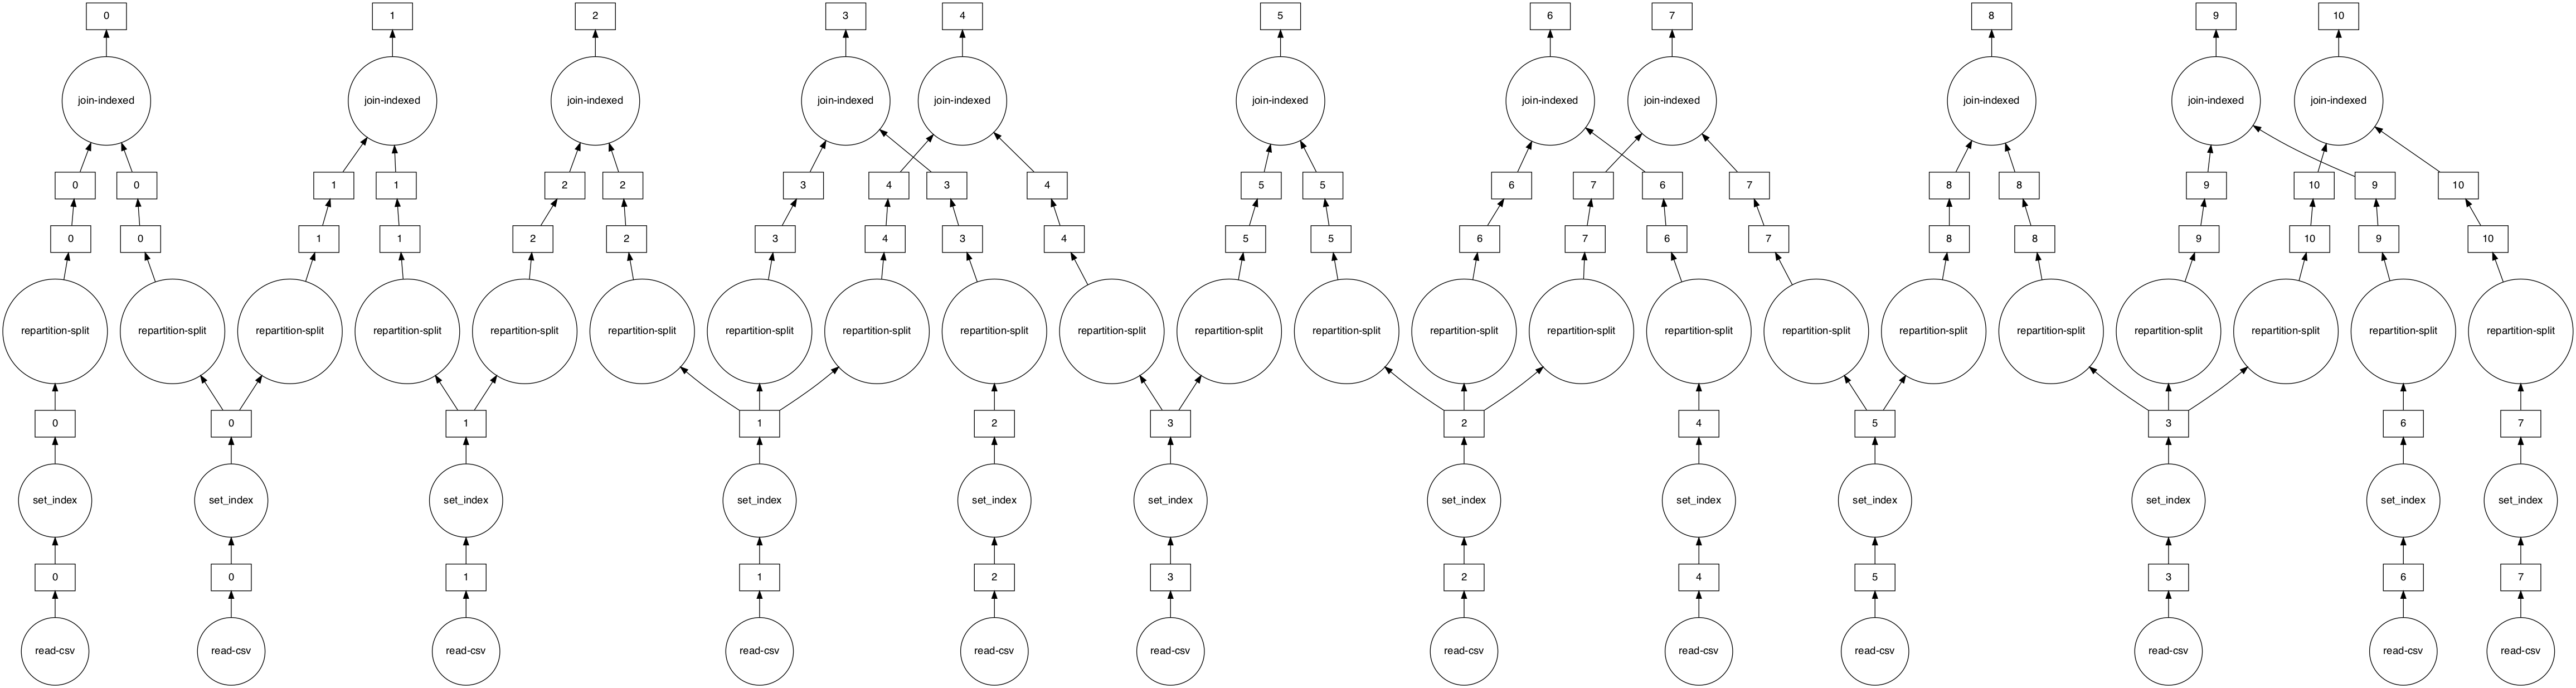

In [267]:
df.merge(df2, left_index=True, right_index=True, how='outer').visualize(optimize_graph=False)

In [254]:
pres = pdf.merge(pdf2, left_index=True, right_index=True, how='outer') # pandas version
res   = df.merge( df2, left_index=True, right_index=True, how='outer').compute() # dask version
assert pres.equals(res) # verify equality
res

,value_x,value_y
key,,
0,0.0,NaN
1,NaN,0.1
2,NaN,0.2
3,NaN,0.3
4,0.4,0.4
...,...,...
93,NaN,9.3
94,NaN,9.4
95,9.5,NaN


In [266]:
futures = client.compute( df.merge( df2, left_index=True, right_index=True, how='outer'), optimize_graph=True )
progress(futures)

VBox()

## Dask Scalability Tests

In [17]:
# rewrite to pandas HDF5 format
import vaex
import dask
import os, os.path
import glob
from tqdm.notebook import tqdm
import pandas as pd
src = glob.glob('output/*/*/catalog.h5')
dest = [ os.path.join(os.path.dirname(fn), 'catalog.parquet') for fn in src ]

@dask.delayed
def convert(fn, destFn):
    df = vaex.open(fn).to_pandas_df()
    df.set_index('hips_pix').sort_index()
    df.to_parquet(destFn)
    return destFn

output = []
for fn, destFn in list(zip(src, dest)):
    fut = convert(fn, destFn)
    output.append(fut)

results = client.compute(output)
progress(*results)

VBox()

## Experiments

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=48, threads_per_worker=1)
client.cluster

### Importer

Code to import the CSV files, store them into .parquet files (for fast loading later), and calculate the statistics needed to come up with good partitioning of the output catalog.

Plotting
CPU times: user 14min 37s, sys: 6min 32s, total: 21min 10s
Wall time: 26min 59s


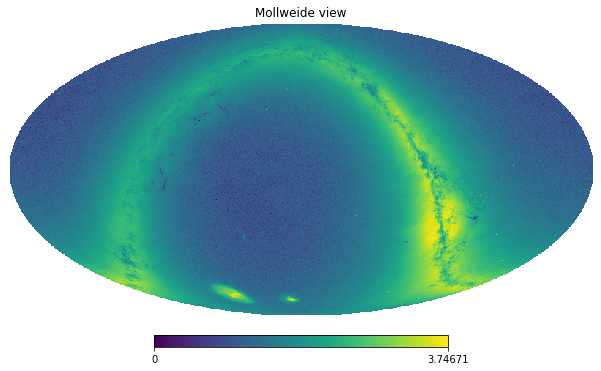

In [10]:
%%time
import numpy as np
import pandas as pd
import healpy as hp
import dask.bag as db
import os
from functools import partial

def _gather_statistics_hpix_hist(parts, k):
    # histogram the list of parts, and return it
    img = np.zeros(hp.order2npix(k), dtype=np.uint32)
    for fn in parts:
        # load the input file
        df = pd.read_csv(fn)
        
        # cache it to a parquet file
        # FIXME: this should abort if the file exists
        parqFn = os.path.join('cache', os.path.basename(fn).split('.')[0] + '.parquet')
        df.to_parquet(parqFn)

        # compute our part of the counts map
        hpix = hp.ang2pix(2**k, df['ra'].values, df['dec'].values, lonlat=True, nest=True)
        hpix, ct = np.unique(hpix, return_counts=True)
        img[hpix] += ct.astype(np.uint32)

    return img

def gather_statistics(files, cache_dir, k=10):
    # files: iterable of files to load
    # cache_dir: output director where to drop file copies (with .parquet extension)
    # k: healpix order of the counts map
    #
    # returns: img (k-order healpix map with object counts)
    os.makedirs(cache_dir)
        
    img = db.from_sequence(urls,partition_size=1).reduction(partial(_gather_statistics_hpix_hist, k=k), sum, split_every=3)
    return img.compute()

import glob
urls = glob.glob('/data2/epyc/data/gaia_edr3_csv/*.csv.gz')
! rm -rf cache
img = gather_statistics(urls, 'cache')

print("Plotting")
hp.mollview(np.log10(img+1), nest=True)

Store the counts map:

In [11]:
import pickle
with open("output/hpix10.counts.pkl", "wb") as fp:
    pickle.dump(img, fp)

Visualize the parquet files by directly reading them:

3386
Computing
Plotting
CPU times: user 10.2 s, sys: 7.32 s, total: 17.5 s
Wall time: 24.4 s


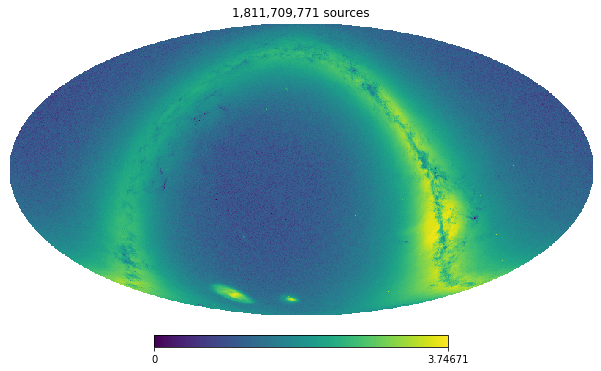

In [4]:
%%time
import dask
import numpy as np
import pandas as pd
import healpy as hp
import dask.bag as db
from functools import partial

import glob
#pqfiles = glob.glob('output/*/*/catalog.parquet')

pqfiles = glob.glob('cache/*.parquet')
print(len(pqfiles))
#pqfiles = pqfiles[:2]

def hpix_hist(parts, k):
    # histogram the list of parts, and return it
    img = np.zeros(hp.order2npix(k), dtype=np.uint32)
    for fn in parts:
        df = pd.read_parquet(fn, columns=['ra', 'dec'])
        hpix = hp.ang2pix(2**k, df['ra'].values, df['dec'].values, lonlat=True, nest=True)
        hpix, ct = np.unique(hpix, return_counts=True)
        img[hpix] += ct.astype(np.uint32)

    return img

print("Computing")
img = db.from_sequence(pqfiles).reduction(partial(hpix_hist, k=10), sum, split_every=8).compute()

print("Plotting")
hp.mollview(np.log10(img+1), title=f'{img.sum():,.0f} sources', nest=True)

Compute the adaptive map by successivelly binning the input pixels.

## Phase 2: Compute the partitioning map

0 12582912 0
1 12582912 0
2 9306112 50
3 4521984 292
4 1630208 706
5 404480 1197
6 9216 1544
7 0 144
8 0 0
9 0 0
10 0 0
Total partitions: 3933
CPU times: user 1.68 s, sys: 834 ms, total: 2.52 s
Wall time: 1.6 s


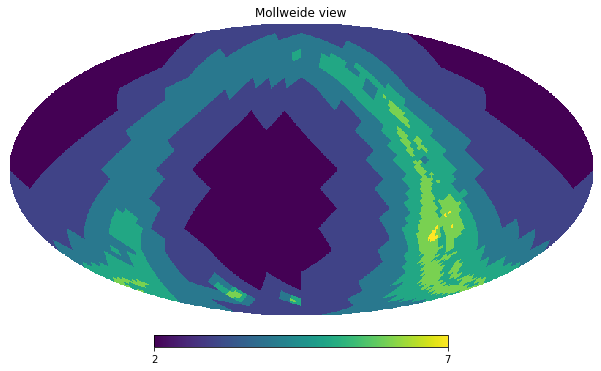

In [5]:
%%time

def compute_partitioning_map(img, max_counts_per_partition=1_000_000):

    # the output
    orders = np.full(len(img), -1) # healpix map of orders
    opix = {}  # dictionary of partitions used at each level

    thresh = max_counts_per_partition

    # Top-down partitioning. Given a dataset partitioned at order k
    # bin it to higher orders (starting at 0, and working our way
    # down to k), and at each order find pixels whose count has
    # fallen below the threshold 'thresh' and record them to be
    # stored at this order.
    #
    # Outputs: opix: dict of order => pixel IDs
    #          orders: a k-order array storing the order at which this k-order pixel should be stored.
    #
    # There's a lot of fun numpy/healpix magic down below, but it all boils
    # down to two things:
    #
    # * In healpix NEST indexing scheme, when the order of the pixelization
    #   is raised by 1, each pixel is subdivided into four subpixels with
    #   pixel IDs [4*idx_o, 4*idx+1, 4*idx+2, 4*idx+3]. That means that if
    #   you need to find out in which _higher_ order pixel some pixel ID
    #   is, just integer-divide it by 4**(k-o) where k is your current order
    #   and o is the higher order. Example: pixel 49 at order 3 fall within
    #   pixel 12 at order 2, 3 at order 1, and 0 at order 0. Easy!
    # * How do you efficiently bin pixels _values_ to a higher order? To go
    #   one order up, you need to sum up groups of 4 pixels in the array
    #   (we're "reversing" the subdivision). If we go up by two orders, it's
    #   groups of 4*4... generally, it's 4**(k-o). This summing can be done
    #   very efficiently with a bit of numpy trickery: reshape the 1-D healpix
    #   array to a 2-d array where the 2nd dimension is equal to 4**(k-o),
    #   and then simply sum along that axis. The result leaves you with the
    #   array rebinned to level o.
    #
    k = hp.npix2order(len(img))
    idx = np.arange(len(img))
    for o in range(0, k+1):
        # the number of order-k pixels that are in one order-o pixel.
        # integer-dividing order-k pixel index (NEST scheme) with 
        # this value will return the order-o index it falls within.
        k2o = 4**(k-o)

        # order o-sized bool mask listing pixels that haven't yet been
        # assigned a partition.
        active = (orders == -1).reshape(-1, k2o).any(axis=1)

        # rebin the image to order o
        imgo = img.reshape(-1, k2o).sum(axis=1)

        # find order o indices where pixel counts are below threshold.
        # These are the one which we will keep at this order.
        pixo, = np.nonzero(active & (imgo < thresh))
        opix[o] = pixo # store output

        # record the order-k indices which have been assigned to the
        # partition at this level (order o). This makes it easy to
        # check which ones are still left to process (see the 'active=...' line above)
        pixk = idx.reshape(-1, k2o)[pixo].flatten()  # this bit of magic generates all order-k 
                                                     # indices of pixels that fall into order-o
                                                     # pixels stored in pixo
        orders[pixk] = o

        print(o, np.count_nonzero(orders == -1), len(pixo))

    assert not (orders == -1).any()
    return orders, opix

orders, opix = compute_partitioning_map(img, 1_000_000)

print("Total partitions:", sum(map(len, opix.values())))
hp.mollview(orders, nest=True)

In [7]:
import pickle
with open("output/orders.hpix10.pkl", "wb") as fp:
    pickle.dump([opix, orders], fp)

Now partition the data according to the computed hierarchy.

In [9]:
import hipscat

def csv2hips(hipsPath, urls, k=6, format='csv', in_format='csv'):
    """
    Convert a list of URLs to CSV files (may be local files) to a HiPS file
    of a given order k.

    :param hipsPath: the output HiPS directory
    :param urls: a list of URLs with GAIA .csv files
    :param k: Healpix order

    :return: Number of records written to each HiPS file
    """
    from functools import reduce
    from tqdm.notebook import tqdm

    # upload the partition map to the workers
    k = client.scatter(k, broadcast=True)

    #
    # Stage #1: Import files in parallel, each into its own leaf .csv file
    #
    stage1 = client.compute([ hipscat._partition_inputs(url, hipsPath=hipsPath, k=k, in_format=in_format) for url in urls ])#, scheduler='single-threaded')
    prog = tqdm(as_completed(stage1, with_results=True), total=len(urls))
    summary = None
    for _, df in prog:
            # FIXME: this changes the datatype to float... grrr...
            summary = summary.add(df, fill_value=0).astype(int) if summary is not None else df

            # give us the number of rows imported
            prog.set_postfix({'rows imported': int(summary.sum())})

    #
    # Stage #2: Merge the individual leaf files into a single file per partition
    #
    stage2 = client.compute([ hipscat._compactify_partitions(idx, hipsPath=hipsPath, outFn='catalog', format=format) for idx in summary.index ])
    for _ in tqdm(as_completed(stage2), total=len(summary)):
        pass

    return summary

urls = glob.glob('cache/*.parquet')

! rm -rf output2
! mkdir output2
summary = csv2hips('output2', urls, k=orders, format='parquet', in_format='parquet')

print(summary)
print(f'Total rows imported: {summary.sum()}')    

  0%|          | 0/3386 [00:00<?, ?it/s]

distributed.utils - ERROR - '<' not supported between instances of 'NoneType' and 'tuple'
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/utils.py", line 648, in log_errors
    yield
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 3108, in graph_doc
    graph = TaskGraph(scheduler, sizing_mode="stretch_both")
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 1937, in __init__
    self.layout = GraphLayout(scheduler)
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/diagnostics/graph_layout.py", line 39, in __init__
    self.update_graph(
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/diagnostics/graph_layout.py", line 49, in update_graph
    stack = sorted(t

  0%|          | 0/3933 [00:00<?, ?it/s]

distributed.utils - ERROR - '<' not supported between instances of 'NoneType' and 'tuple'
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/utils.py", line 648, in log_errors
    yield
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 3108, in graph_doc
    graph = TaskGraph(scheduler, sizing_mode="stretch_both")
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/dashboard/components/scheduler.py", line 1937, in __init__
    self.layout = GraphLayout(scheduler)
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/diagnostics/graph_layout.py", line 39, in __init__
    self.update_graph(
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/diagnostics/graph_layout.py", line 49, in update_graph
    stack = sorted(t

hips_k  hips_pix
2       0           726621
        2           837288
        17          760490
        19          907422
        20          599147
                     ...  
7       117019      245326
        117040      265447
        117041      266297
        117042      264911
        117043      234619
Length: 3933, dtype: int64
Total rows imported: 1811709771


## Catalog loader experiment

In [2]:
%load_ext line_profiler

With dask.bag:

In [42]:
%%time
import dask
from dask import delayed
from dask.distributed import as_completed
import numpy as np
import pandas as pd
import healpy as hp
import dask.bag as db
import os
from functools import partial
from tqdm.notebook import tqdm
k=10

import glob

def _hist_parts(parts, k, lon, lat):
    # histogram the dataframe(s), and return the image
    img = np.zeros(hp.order2npix(k), dtype=np.uint32)
    for df in parts:
#        print(f"Binning... {len(df)}")
        hpix = hp.ang2pix(2**k, df[lon].values, df[lat].values, lonlat=True, nest=True)
        hpix, ct = np.unique(hpix, return_counts=True)
        img[hpix] += ct.astype(np.uint32)

    return img

def histogram(t, k=10, lon='ra', lat='dec'):
    return t.reduction(partial(_hist_parts, k=k, lon=lon, lat=lat), sum)

def _read_partitions(parts, *args, **kwargs):
#    print("_read_partitions", parts)
#    return (pd.read_parquet(part, *args, **kwargs) for part in parts)
    def iterator(parts):
        for part in parts:
#            print("Reading", part)
            yield pd.read_parquet(part, *args, **kwargs)
    return iterator(parts)

def read_hipscat(path, format='parquet', load_partitions=None, columns=None):
    pattern = os.path.join(path, '*', '*', f'catalog.{format}')
    urls = glob.glob(pattern)
    if load_partitions is not None:
        urls = urls[:load_partitions]

    bag = db.from_sequence(urls).map_partitions(_read_partitions, columns=columns)
    return bag

print("Computing")
t = read_hipscat('output', columns=['l', 'b'], load_partitions=None)
img = histogram(t, lon='l', lat='b')
#img = img.compute(scheduler='single-threaded')
img = img.compute()
#img.visualize()
#fut = client.compute(img)

#print("Plotting")
#hp.mollview(np.log10(img+1), nest=True)

#%lprun -f run2 run2()

Computing
CPU times: user 5.28 s, sys: 4.94 s, total: 10.2 s
Wall time: 15.2 s


In [40]:
progress(fut)


VBox()

distributed.core - ERROR - Exception while handling op get_data
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/core.py", line 498, in handle_comm
    result = await result
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/worker.py", line 1657, in get_data
    assert response == "OK", response
AssertionError: {'op': 'get_data', 'keys': {"('from_sequence-75260fa135c330ab80de0d85e9234598', 100)"}, 'who': 'tcp://127.0.0.1:45550', 'max_connections': None, 'reply': True}
distributed.worker - ERROR - {'op': 'get_data', 'keys': {"('from_sequence-75260fa135c330ab80de0d85e9234598', 100)"}, 'who': 'tcp://127.0.0.1:45550', 'max_connections': None, 'reply': True}
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/worker.py", line 2748, in gather_dep
    response = await get_data_from_worker(
  File "/ep

In [41]:
del fut

In [28]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 48
Total threads: 48,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37121,Workers: 48
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: 18 minutes ago,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:45930,Total threads: 1
Dashboard: http://127.0.0.1:44301/status,Memory: 20.99 GiB
Nanny: tcp://127.0.0.1:46537,


With dask.dataframe

In [162]:
pd.DataFrame(dict(img=[np.arange(3), np.arange(3), np.arange(3)])).sum()

img    [0, 3, 6]
dtype: object

In [2]:
class foo:
    def __init__(self, v):
        self.v = v

In [189]:
%%time

import pandas as pd

def partmap(df, k=10, lon='l', lat='b', partition_info=None):
    img = np.zeros(hp.order2npix(k), dtype=np.uint32)

    hpix = hp.ang2pix(2**k, df[lon].values, df[lat].values, lonlat=True, nest=True)
    hpix, ct = np.unique(hpix, return_counts=True)
    img[hpix] += ct.astype(np.uint32)

    return foo(img)

def agg(df):
    #print('AGG:', df, len(df))
    # This dataframe has _rows_ labeled 'img' and a single column indexed 0
    return foo(sum(v.v for v in df))

df = read_hipscat_df('output', columns=['l', 'b'], load_partitions=None)\
    .map_partitions(partmap, meta=(object))\
    .reduction(lambda x: x, agg, meta=(object))\
    .compute()#(scheduler='single-threaded')
print(df.v.sum())
df = df.v
df
##fut = client.compute(df)

KeyboardInterrupt: 

In [32]:
%%time
import dask
from dask import delayed
from dask.distributed import as_completed
import dask.dataframe as dd
import numpy as np
import pandas as pd
import healpy as hp
import dask.bag as db
import os
from functools import partial
from tqdm.notebook import tqdm
import pandas as pd
import glob

def _hpix_map(df, k=10, lon='l', lat='b', partition_info=None):
    img = np.zeros(hp.order2npix(k), dtype=np.uint32)

    hpix = hp.ang2pix(2**k, df[lon].values, df[lat].values, lonlat=True, nest=True)
    hpix, ct = np.unique(hpix, return_counts=True)
    img[hpix] += ct.astype(np.uint32)

    return pd.Series([img], name='img')

def _hpix_map_agg(df):
    ##print('AGG:', df)
    # This dataframe has _rows_ labeled 'img' and column indexed 0
    img = sum(df[0])
    return pd.Series([img], name='img')

@dask.delayed
def get_scalar(ser):
    return ser[0]

def histogram(df, k=10, lon='ra', lat='dec'):
    return get_scalar(
        df
        .map_partitions(_hpix_map, meta=('img', object))
        .reduction(lambda x: x, _hpix_map_agg, split_every=24, meta=('img', object))
    )

def read_hipscat(path, format='parquet', load_partitions=None, columns=None):
    pattern = os.path.join(path, '*', '*', f'catalog.{format}')
    urls = glob.glob(pattern)
    if load_partitions is not None:
        urls = urls[:load_partitions]

    df = dd.read_parquet(urls, columns=columns)
    return df

df = read_hipscat('output', columns=['l', 'b'], load_partitions=None);
img = histogram(df, k=10, lon='l', lat='b')
##img = img.compute(scheduler='single-threaded')
#print(sum(img[0]).sum())
##img
fut = client.compute(img)

CPU times: user 16.5 s, sys: 1.01 s, total: 17.5 s
Wall time: 16.8 s


In [33]:
progress(fut)

VBox()

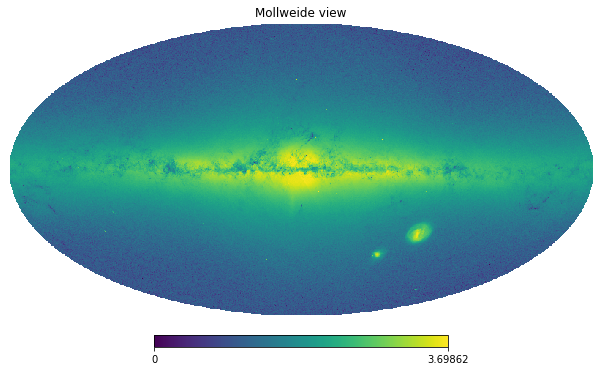

In [31]:
img = fut.result()
hp.mollview(np.log10(img+1), nest=True)
del fut

In [127]:
del fut

In [24]:
%%time
import dask
from dask import delayed
from dask.distributed import as_completed
import dask.dataframe as dd
import numpy as np
import pandas as pd
import healpy as hp
import dask.bag as db
import os
from functools import partial
from tqdm.notebook import tqdm
k=10

import glob

def _hist_parts2(df, k, lon, lat):
    # histogram the dataframe(s), and return the image
    img = np.zeros(hp.order2npix(k), dtype=np.uint32)

    hpix = hp.ang2pix(2**k, df[lon].values, df[lat].values, lonlat=True, nest=True)
    hpix, ct = np.unique(hpix, return_counts=True)
    img[hpix] += ct.astype(np.uint32)
    print("HERE", img.shape, img.sum(), type(img))

    return pd.DataFrame(dict(img=[ img ]))

def histogram2(t, k=10, lon='ra', lat='dec'):
    img = t.map_partitions(
        _hist_parts, k=k, lon=lon, lat=lat
    ).reduction(lambda x: x, sum, meta=(None, object))
    return img

def read_hipscat_df(path, format='parquet', load_partitions=None, columns=None):
    pattern = os.path.join(path, '*', '*', f'catalog.{format}')
    urls = glob.glob(pattern)
    if load_partitions is not None:
        urls = urls[:load_partitions]

    df = dd.read_parquet(urls, columns=columns)
    return df

print("Computing")
df = read_hipscat_df('output', load_partitions=2, columns=['l', 'b'])
#img = histogram(t, lon='l', lat='b')
#img = img.compute(scheduler='single-threaded')
#img.visualize()

#print("Plotting")
#hp.mollview(np.log10(img+1), nest=True)

Computing
CPU times: user 81.4 ms, sys: 67.9 ms, total: 149 ms
Wall time: 105 ms


In [48]:
t.npartitions

10

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=48, threads_per_worker=1)
client.cluster

distributed.diskutils - INFO - Found stale lock file and directory '/nvme/users/mjuric/github.com/mjuric/HIPS/dask-worker-space/worker-qyoeebf6', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nvme/users/mjuric/github.com/mjuric/HIPS/dask-worker-space/worker-9cfm0857', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nvme/users/mjuric/github.com/mjuric/HIPS/dask-worker-space/worker-3akbmvx0', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nvme/users/mjuric/github.com/mjuric/HIPS/dask-worker-space/worker-p2uca9q3', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nvme/users/mjuric/github.com/mjuric/HIPS/dask-worker-space/worker-iqxiaqha', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nvme/users/mjuric/github.com/mjuric/HIPS/dask-worker-space/worker-axgwl6aq', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nvme/us

Computing
Plotting
CPU times: user 59.6 s, sys: 24.2 s, total: 1min 23s
Wall time: 1min 33s


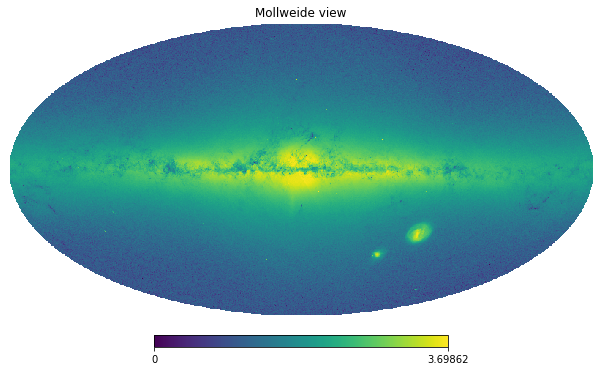

In [6]:
%%time

import numpy as np
import healpy as hp
import dask
import os, glob
import dask.bag as db
import dask.dataframe as dd
from functools import partial
from dask.distributed import worker_client, as_completed

def _hist_parts(parts, k, lon, lat):
    # histogram the dataframe(s), and return the image
##    print("XXXXX", type(parts), len(parts), type(parts[0]))
    img = np.zeros(hp.order2npix(k), dtype=np.uint32)
    with worker_client() as client:
        parts = client.compute(parts)
#    if True:
        for df in as_completed(parts):
#            df = df.compute(scheduler='single-threaded')
####            df = df.compute()
            df = df.result()
##            print(f"Histogramming {len(df)}")
            hpix = hp.ang2pix(2**k, df[lon].values, df[lat].values, lonlat=True, nest=True)
            hpix, ct = np.unique(hpix, return_counts=True)
            img[hpix] += ct.astype(np.uint32)

    return img

def trace_part(df):
    print(f"Loaded {len(df)}")
    return df

def histogram(t, k=10, lon='ra', lat='dec'):
    return t.reduction(partial(_hist_parts, k=k, lon=lon, lat=lat), sum)

def read_hipscat_df(path, format='parquet', load_partitions=None, columns=None):
    pattern = os.path.join(path, '*', '*', f'catalog.{format}')
    urls = glob.glob(pattern)
    if load_partitions is not None:
        urls = urls[:load_partitions]

    df = dd.read_parquet(urls, columns=columns)
    return df

@dask.delayed
def make_delayed(var):
    return var

def chunk(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

print("Computing")
df = read_hipscat_df('output', load_partitions=None, columns=['l', 'b'])#.map_partitions(trace_part)
# convert to a bag of dataframes
#dl = [ make_delayed(lst) for lst in chunk(df.to_delayed(), 5) ]
#t = db.from_delayed(dl)
t = db.from_sequence(df.to_delayed())

img = histogram(t, lon='l', lat='b')
#img = img.compute(scheduler='single-threaded')
img = img.compute(optimize_graph=False)
#img.visualize()

print("Plotting")
hp.mollview(np.log10(img+1), nest=True)

In [16]:
%%time

import numpy as np
import healpy as hp
import dask
import os, glob
import dask.bag as db
import dask.dataframe as dd
from functools import partial
from dask.distributed import worker_client, as_completed, progress

def _hist_parts(parts, k, lon, lat):
    # histogram the dataframe(s), and return the image
    img = np.zeros(hp.order2npix(k), dtype=np.uint32)
    for df in parts:
        hpix = hp.ang2pix(2**k, df[lon].values, df[lat].values, lonlat=True, nest=True)
        hpix, ct = np.unique(hpix, return_counts=True)
        img[hpix] += ct.astype(np.uint32)

    return img

def trace_part(df):
    print(f"Loaded {len(df)}")
    return df

def histogram(t, k=10, lon='ra', lat='dec'):
    return t.reduction(partial(_hist_parts, k=k, lon=lon, lat=lat), sum)

def read_hipscat_df(path, format='parquet', load_partitions=None, columns=None):
    pattern = os.path.join(path, '*', '*', f'catalog.{format}')
    urls = glob.glob(pattern)
    if load_partitions is not None:
        urls = urls[:load_partitions]

    df = dd.read_parquet(urls, columns=columns)
    return df

@dask.delayed
def make_delayed(var):
    return var

def chunk(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

print("Computing")
df = read_hipscat_df('output', load_partitions=None, columns=['l', 'b'])#.map_partitions(trace_part)
# convert to a bag of dataframes
dl = [ make_delayed(lst) for lst in chunk(df.to_delayed(), 1) ]
t = db.from_delayed(dl)

img = histogram(t, lon='l', lat='b')
#img = img.compute(scheduler='single-threaded')
#img = img.compute(optimize_graph=False)
#img.visualize()

fut = client.compute(img, optimize_graph=False)
#progress(fut)

#print("Plotting")
#hp.mollview(np.log10(img+1), nest=True)

Computing
CPU times: user 6.44 s, sys: 521 ms, total: 6.96 s
Wall time: 6.54 s


In [17]:
progress(fut)

VBox()

## Stuff

In [4]:
import numpy as np
gaia['_x'] = (gaia['l'] / 0.5).astype(int)
gaia['_y'] = ((gaia['b'] + 90) / 0.5).astype(int)
res = gaia.groupby(['_x', '_y'])['l'].count()
res

Dask Series Structure:
npartitions=1
    int64
      ...
Name: l, dtype: int64
Dask Name: series-groupby-count-agg, 547695 tasks

In [5]:
#df.count().compute()
#res = df.count()
futures = client.compute(res)
progress(futures)

VBox()

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x7f29cf655e80>>, <Task finished name='Task-1196' coro=<MultiProgressBar.listen() done, defined at /epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/diagnostics/progressbar.py:239> exception=OSError('Timed out during handshake while connecting to tcp://127.0.0.1:34798 after 3 s')>)
Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/site-packages/distributed/comm/tcp.py", line 205, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/epyc/ssd/users/mjuric/miniconda3/envs/lsd2/lib/python3.9/asyncio/tasks.py", line 492, in wait_for
    fut.result()
asyncio.exceptions.CancelledError

The

In [6]:
progress(futures)

VBox()

In [7]:
res = futures.result()
res

_x   _y 
245  232    1700
     233    1621
     234    1565
246  232    1701
     233    1513
            ... 
605  125    3213
606  125    3430
604  126    3674
605  126    3661
606  126    3700
Name: l, Length: 259124, dtype: int64

In [8]:
img = np.zeros(shape=(180*4, 90*4))
df = res.reset_index()
img[df['_x'], df['_y']] = np.log10(df['l'])

1811709847.0

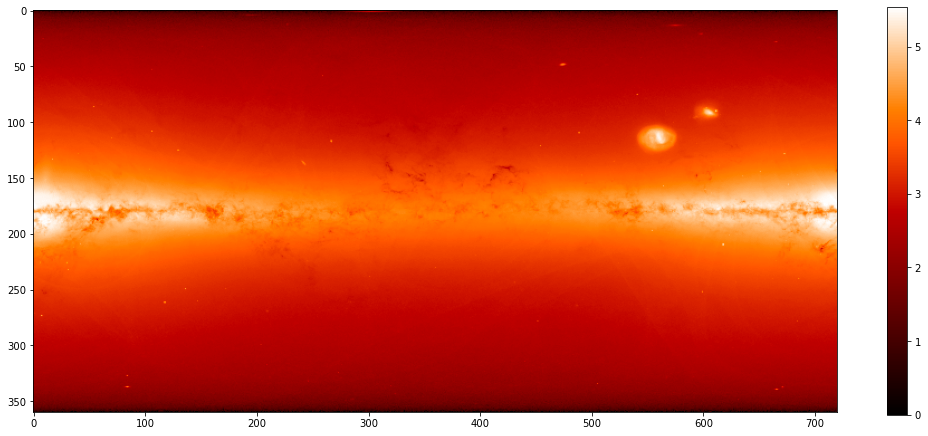

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,7.5))
plt.imshow(img.T, cmap='gist_heat')
plt.colorbar()
np.power(10, img).sum()

## API

In [ ]:
gaia = df.from_hips("s3://dirac/gaia")
sdss = df.from_hips("s3://dirac/sdss")

df = sdss.crossmatch(gaia, radius=1*u.as).select_circle(skypoint, radius=2u)
df.compute()

## More tests

In [98]:
pdf = pd.DataFrame(dict(key=np.arange(100, dtype=int), value=np.arange(100)/10))
df = dd.from_pandas(pdf, npartitions=5).set_index('key', sorted=True)

pdf2 = pd.DataFrame(dict(key=np.arange(100, dtype=int), value=np.arange(100)/10))
df2 = dd.from_pandas(pdf2, npartitions=5).set_index('key', sorted=True)

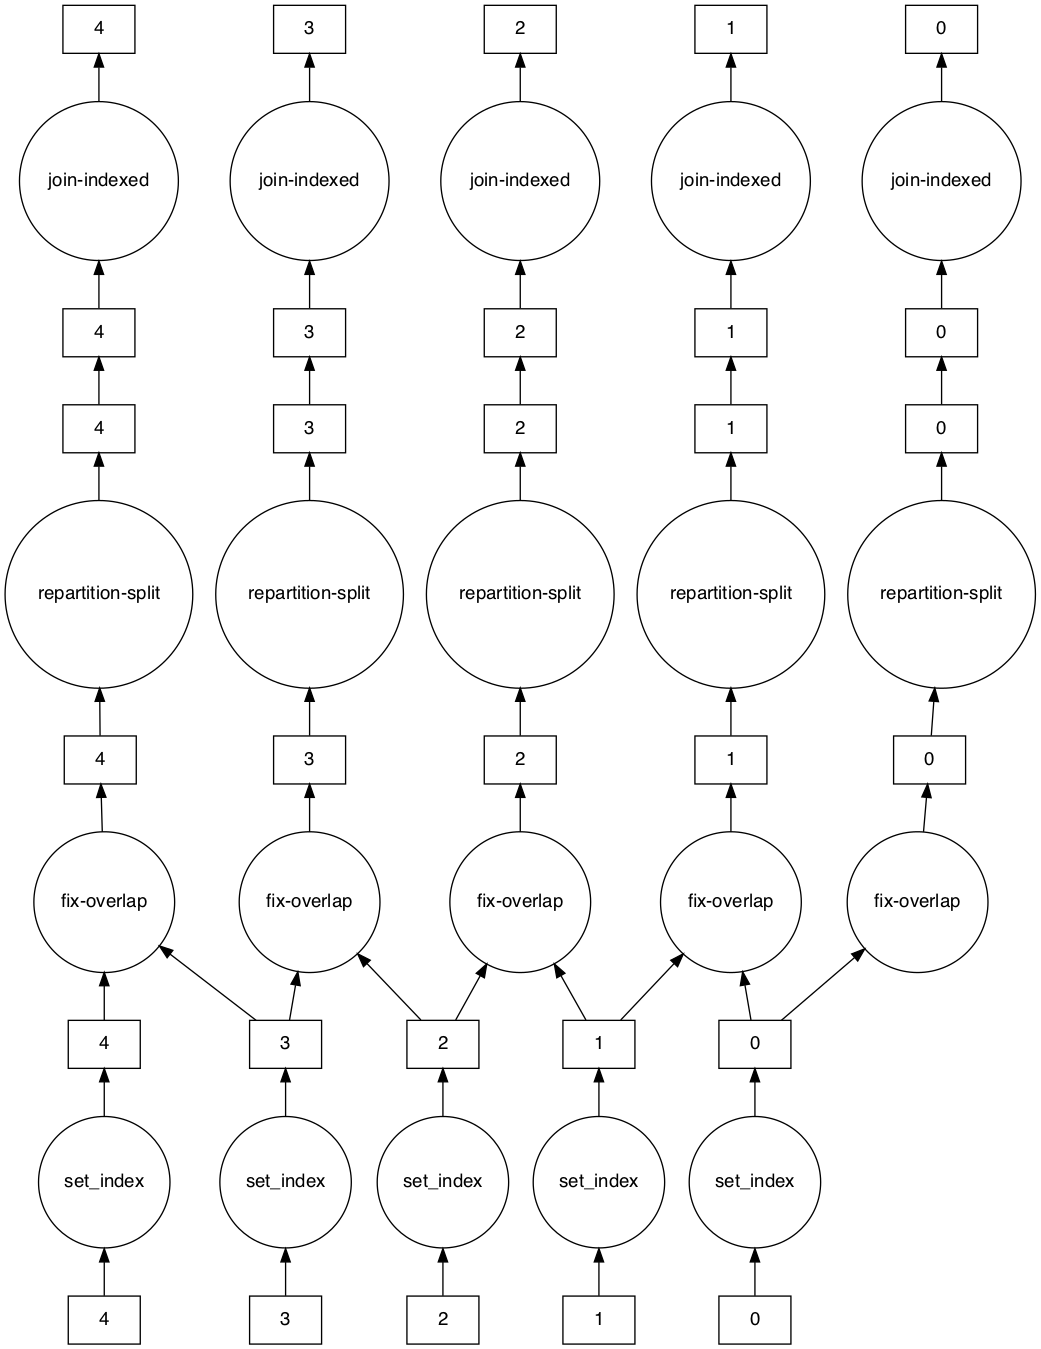

In [99]:
df.merge(df2, left_index=True, right_index=True).visualize()

In [4]:
import vaex
import pandas as pd
ff = ['output//Norder5/Npix652/catalog.h5', 'output//Norder5/Npix2201/catalog.h5', 'output//Norder5/Npix3920/catalog.h5']
ff2 = []
for fn in ff:
    df = vaex.open(fn)
    df = df.to_pandas_df()
    destFn='-'.join(fn.split('/')[-2:])
    print(fn, destFn)
    ff2.append(destFn)
    df = df.set_index('hips_pix').sort_index()
    df.to_hdf(destFn, key='catalog', format='table', complib='blosc:lz4', complevel=9)

output//Norder5/Npix652/catalog.h5 Npix652-catalog.h5
output//Norder5/Npix2201/catalog.h5 Npix2201-catalog.h5
output//Norder5/Npix3920/catalog.h5 Npix3920-catalog.h5


In [5]:
df = dd.read_hdf(ff2, key='catalog', sorted_index=True)
df

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,hips_k
npartitions=3,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
652,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,int64,int64,float64,int64,int64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
2201,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
! cp *.h5 cat2/
cat2ff = [ f'cat2/{fn}' for fn in ff2 ]
df2 = dd.read_hdf(ff2, key='catalog', sorted_index=True)
df2

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,hips_k
npartitions=3,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
652,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,int64,int64,float64,int64,int64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
2201,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


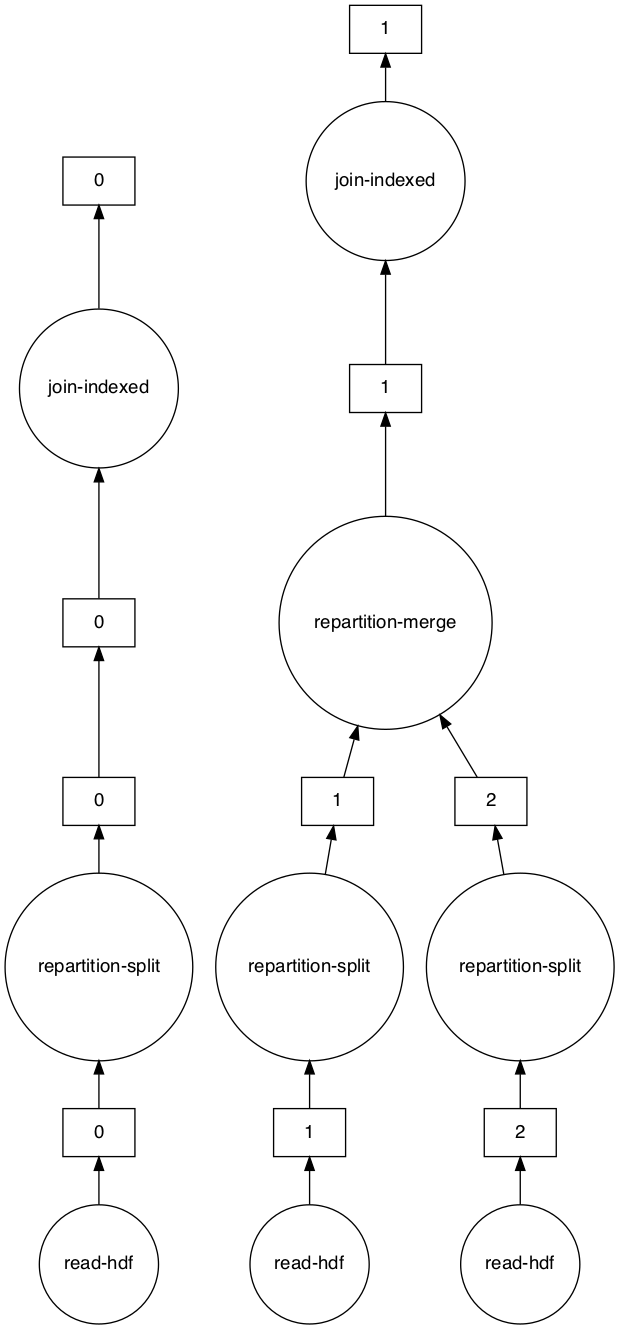

In [8]:
df.merge(df2, left_index=True, right_index=True).visualize()

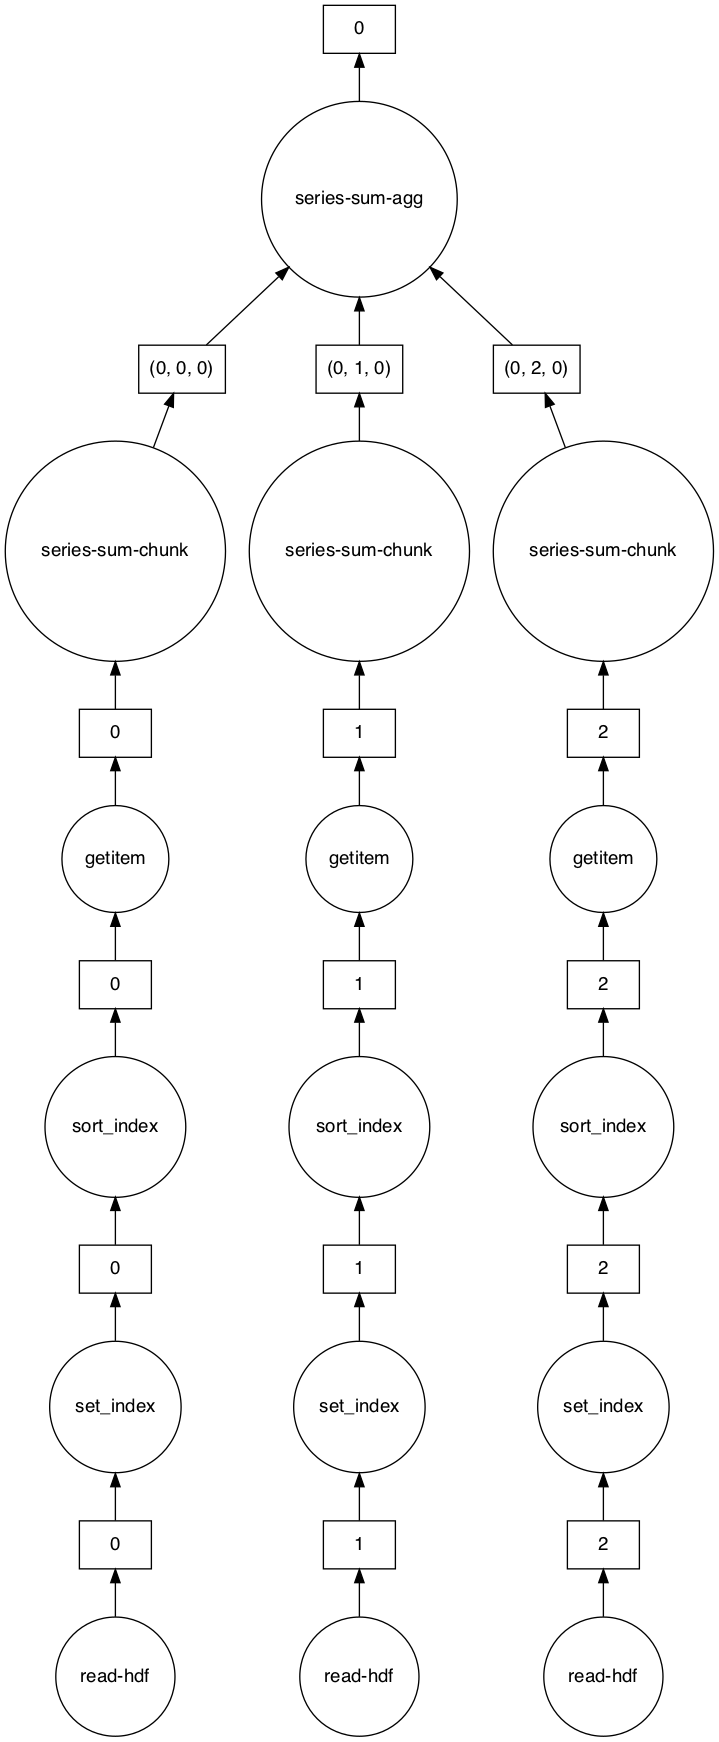

In [56]:
df['ra'].sum().visualize()